# Perform a grid search to find the timing error

In [1]:
import os
import sys
# Append parent directory to import path so lib can be found
sys.path.append(os.path.dirname(os.path.abspath(os.getcwd())))

import numpy as np
rng = np.random.default_rng(12345)

import matplotlib.pyplot as plt
from scipy import signal
import copy

from lib.signals import DigitisedSignal
import lib.util as util


km = 1e3
ns = 1e9

# monkey patch correlation_lags into signal if it does not exist
if not hasattr(signal, 'correlation_lags'):
    def correlation_lags(in1_len, in2_len, mode='full'):
        r"""
        Calculates the lag / displacement indices array for 1D cross-correlation.
        Parameters
        ----------
        in1_size : int
            First input size.
        in2_size : int
            Second input size.
        mode : str {'full', 'valid', 'same'}, optional
            A string indicating the size of the output.
            See the documentation `correlate` for more information.
        See Also
        --------
        correlate : Compute the N-dimensional cross-correlation.
        Returns
        -------
        lags : array
            Returns an array containing cross-correlation lag/displacement indices.
            Indices can be indexed with the np.argmax of the correlation to return
            the lag/displacement.
        Notes
        -----
        Cross-correlation for continuous functions :math:`f` and :math:`g` is
        defined as:
        .. math::
            \left ( f\star g \right )\left ( \tau \right )
            \triangleq \int_{t_0}^{t_0 +T}
            \overline{f\left ( t \right )}g\left ( t+\tau \right )dt
        Where :math:`\tau` is defined as the displacement, also known as the lag.
        Cross correlation for discrete functions :math:`f` and :math:`g` is
        defined as:
        .. math::
            \left ( f\star g \right )\left [ n \right ]
            \triangleq \sum_{-\infty}^{\infty}
            \overline{f\left [ m \right ]}g\left [ m+n \right ]
        Where :math:`n` is the lag.
        Examples
        --------
        Cross-correlation of a signal with its time-delayed self.
        >>> from scipy import signal
        >>> from numpy.random import default_rng
        >>> rng = default_rng()
        >>> x = rng.standard_normal(1000)
        >>> y = np.concatenate([rng.standard_normal(100), x])
        >>> correlation = signal.correlate(x, y, mode="full")
        >>> lags = signal.correlation_lags(x.size, y.size, mode="full")
        >>> lag = lags[np.argmax(correlation)]
        """

        # calculate lag ranges in different modes of operation
        if mode == "full":
            # the output is the full discrete linear convolution
            # of the inputs. (Default)
            lags = np.arange(-in2_len + 1, in1_len)
        elif mode == "same":
            # the output is the same size as `in1`, centered
            # with respect to the 'full' output.
            # calculate the full output
            lags = np.arange(-in2_len + 1, in1_len)
            # determine the midpoint in the full output
            mid = lags.size // 2
            # determine lag_bound to be used with respect
            # to the midpoint
            lag_bound = in1_len // 2
            # calculate lag ranges for even and odd scenarios
            if in1_len % 2 == 0:
                lags = lags[(mid-lag_bound):(mid+lag_bound)]
            else:
                lags = lags[(mid-lag_bound):(mid+lag_bound)+1]
        elif mode == "valid":
            # the output consists only of those elements that do not
            # rely on the zero-padding. In 'valid' mode, either `in1` or `in2`
            # must be at least as large as the other in every dimension.

            # the lag_bound will be either negative or positive
            # this let's us infer how to present the lag range
            lag_bound = in1_len - in2_len
            if lag_bound >= 0:
                lags = np.arange(lag_bound + 1)
            else:
                lags = np.arange(lag_bound, 1)
        return lags

    signal.correlation_lags = correlation_lags

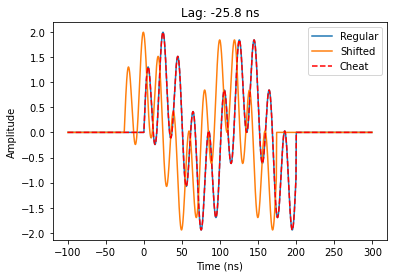

In [2]:
# Setup signal
########################

signal_t_length = 200e-9
signal_sample_rate = 5e9 # Hz
signal_time = util.sampled_time(
    sample_rate=signal_sample_rate,
    start=0,
    end=signal_t_length
)
double_signal_time = np.concatenate((signal_time, signal_time[-1] + signal_time)) \
                     - (signal_time[-1] - signal_time[0])/2

fc = 50e6# MHz

if True:

    shift = -25.8e-9
    signal_pulse1_center = 125e-9 # 100 ns
    
    if not True:
        signal_1 = DigitisedSignal(signal.gausspulse(signal_time - signal_pulse1_center, fc=fc),
                                   signal_sample_rate)
        signal_2 = DigitisedSignal(signal.gausspulse(signal_time - signal_pulse1_center, fc=fc), 
                                   signal_sample_rate)
        signal_2.t_0 = shift
    else:
        signal_1 = DigitisedSignal(np.sin(2*np.pi*(signal_time)*fc/5.4) + np.sin(2*np.pi*(signal_time)*fc),
                                   signal_sample_rate)

        signal_2 = copy.copy(signal_1)
        signal_2.t_0 = shift
   
    signal_1.periodic = False
    signal_2.periodic = False
    del signal_pulse1_center


del fc, signal_t_length, signal_sample_rate


# Pre calculated values
sig_1 = signal_1(double_signal_time)
sig_2 = signal_2(double_signal_time)


if True:
    fig, ax = plt.subplots()
    ax.plot(double_signal_time * ns, sig_1, label='Regular')
    ax.plot((double_signal_time) * ns, sig_2, label="Shifted")
    ax.plot((double_signal_time) * ns, signal_2(double_signal_time + shift), 'r--', label="Cheat")
    ax.set_xlabel("Time (ns)")
    ax.set_ylabel("Amplitude")
    ax.set_title("Lag: {:.4g} ns".format(shift*ns))
    plt.legend()
    plt.show()

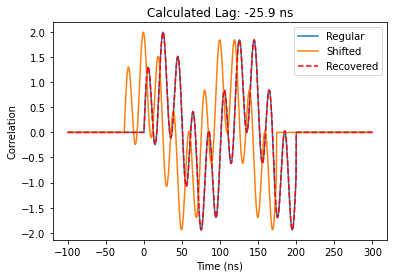

In [3]:
## Using scipy

if True:
    scipy_corr = signal.correlate(sig_1, sig_2, mode='same')
    scipy_id = scipy_corr.argmax()
    calc_shift =  ((len(scipy_corr)-1)/2 -scipy_id)/signal_1.sample_rate

    if not True:
        signal_2.periodic = True

    fig, ax = plt.subplots()
    ax.plot(double_signal_time * ns, sig_1, label='Regular')
    ax.plot((double_signal_time) * ns, sig_2, label="Shifted")
    ax.plot((double_signal_time) * ns, signal_2(double_signal_time + calc_shift), 'r--', label='Recovered')
    ax.set_xlabel("Time (ns)")
    ax.set_ylabel("Correlation")
    ax.set_title("Calculated Lag: {:.4g} ns".format(calc_shift*ns))
    ax.legend()
    plt.show()

## new code

In [4]:
def lag_gridsearch(grid, sample_rate, signal_data, reference):
    """
    Return the best time shift found when doing a grid search.
    
    Parameters
    ----------
    lag_grid - ndarray
        The array specifying the grid that is to be searched.
    sample_rate - float
        Sample rate of signal_data to transform index to time.
    signal_data - ndarray
        The real signal to find the time shift for.
    reference - ndarray
        Real signal to use as reference to obtain lag.
        
    Returns
    -------
    lag : ndarray
        The best time shift obtained
    err : tuple
        Difference to the previous and next time shift from lag, resp.
    """

    assert signal_data.shape == reference.shape
    
    corrs = grid_correlate(grid, signal_data, reference)
    
    idx = np.argmax(corrs)
    
    lag = grid[idx]/sample_rate
    
    err_min =  (grid[idx-1]-grid[idx])/(2*sample_rate)
    err_plus = (grid[idx+1]-grid[idx])/(2*sample_rate)

    return lag, (err_min, err_plus)
    

def grid_correlate(grid, x, reference):
    """
    Determine correlation between x and reference using grid as 
    the lags to be used for the correlation.
    
    Parameters
    ----------
    grid - ndarray
        The array specifying the grid that is to be searched.
    x - ndarray
        The real signal to find the time shift for.
    reference - ndarray
        Real signal to use as reference to obtain lag.
        
    Returns
    -------
    corrs - ndarray
        The correlations along grid.
    """
    grid = np.asarray(grid)
    x = np.asarray(x)
    reference = np.asarray(reference)

    assert x.shape == reference.shape
    
    ref_conj = np.conjugate(reference)
    
    corrs = np.array([np.dot(np.roll(ref_conj, lag), x) for lag in grid], dtype=np.float64)
    
    return corrs

def correlation_grid(grid_size=None, in1_len=None, in2_len = None, end = None, start=None, mode='full'):
    """
    Abuse correlation_lags to determine the endpoints of the grid.
    """
    
    if in1_len is not None or in2_len is not None:
        if in2_len is None:
            in2_len = in1_len
        elif in1_len is None:
            in1_len = in2_len

        lags = signal.correlation_lags(in1_len, in2_len, mode=mode)

        max_lag = max(lags)
        min_lag = min(lags)
    else:
        max_lag = np.inf
        min_lag = -np.inf

    if end is None:
        end = max_lag
    elif end > max_lag:
        raise ValueError("Grid end is too high")

    if start is None:
        start = min_lag
    elif start < min_lag:
        raise ValueError("Grid start is too low")

    return np.linspace(start, end, grid_size, dtype=int, endpoint=False)

## Debug and test functions

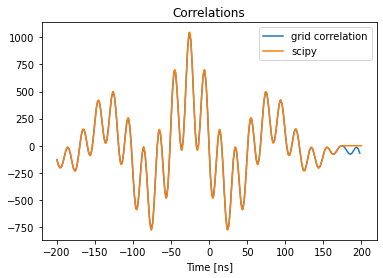

ids 87 871
ts -2.62e-08 -2.58e-08 =: -2.58e-08
avail ts -2e-07 - 1.978e-07 : 1.989e-09
grid size 200 2000 2000


In [5]:
#################
grid_size = 200
my_mode = 'same'
grid = correlation_grid(grid_size, in1_len=len(sig_1), in2_len=len(sig_2), mode=my_mode)
t_grid = grid/signal_1.sample_rate

scipy_mode = my_mode
scipy_corr = signal.correlate(sig_2, sig_1, mode=scipy_mode)
scipy_lags = signal.correlation_lags(len(sig_2), len(sig_1), mode=scipy_mode)
corrs = grid_correlate(grid, sig_2, sig_1)
   

scipy_id = np.argmax(scipy_corr)
my_id = np.argmax(corrs)


fig, ax = plt.subplots()
ax.set_title("Correlations")

if not True:
    x_grid = grid
    scipy_grid = scipy_lags
    ax.set_xlabel("Index Lag")
else:
    x_grid = t_grid * 1e9
    scipy_grid = scipy_lags / signal_1.sample_rate * 1e9
    ax.set_xlabel("Time [ns]")
    
ax.plot(x_grid, corrs, label='grid correlation')
ax.plot(scipy_grid, scipy_corr, label='scipy')

ax.legend()

plt.show();


if scipy_mode == 'same':
    scipy_corr_grid = scipy_corr[grid]
else:
    scipy_corr_grid = scipy_corr[grid]
    

if len(grid) <= 10:
    print("G", grid)
    print("TG", grid/signal_1.sample_rate)
    print("C", corrs)
    print("SC", scipy_corr_grid)
    
    
print("ids", my_id, scipy_id)
print("ts", t_grid[my_id], scipy_lags[np.argmax(scipy_corr)]/signal_1.sample_rate, '=:', signal_2.t_0)
print("avail ts", t_grid[0], '-', t_grid[-1] ,':', (t_grid[-1] - t_grid[0])/len(t_grid))
print("grid size", len(t_grid), len(sig_2), len(sig_1))

## Showcase functions

Known time offset: -2.58e-08
Calculated offset: -2.62e-08
Uncertainty on offset: (-1e-09, 1e-09)


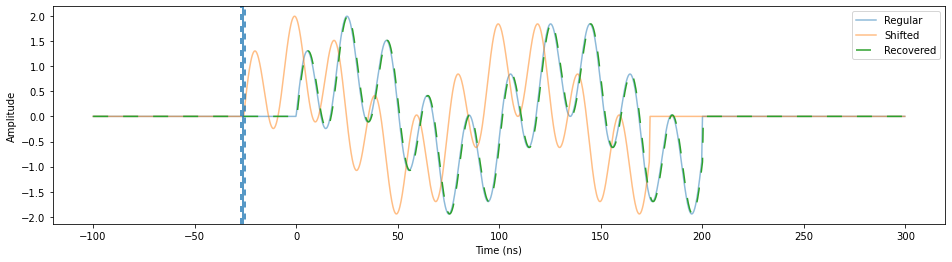

In [6]:
grid_size = 200

grid = correlation_grid(grid_size, in1_len=len(sig_1), in2_len=len(sig_2), mode='same')
calc_shift, err = lag_gridsearch(grid, signal_1.sample_rate, sig_2, sig_1)

print("Known time offset:", signal_2.t_0)
print("Calculated offset:", calc_shift)
print("Uncertainty on offset:", err)

if True:
    signal_2.periodic = False

fig, ax = plt.subplots(figsize=(16,4))
ax.plot(double_signal_time   * ns, sig_1, alpha=0.5, label='Regular')
ax.plot(double_signal_time   * ns, sig_2, alpha=0.5, label='Shifted')
ax.plot((double_signal_time) * ns, signal_2(double_signal_time + calc_shift), ls=(0, (10,)), label='Recovered')


ax.axvline(calc_shift * ns)
for i, _ in enumerate(err):
    ax.axvline((calc_shift + err[i]) * ns, ls=(5*i, (4, 4)))

ax.set_xlabel("Time (ns)")
ax.set_ylabel("Amplitude")
ax.legend()

plt.show()